## Most Recent AAPL Options

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

from LSMPricing import lsm_pricer
from BinomialTreePricing import btree_pricer
from BSAnalyticalPricing import BSAnalytical
from MonteCarlo import simulate_gbm_paths

## Download AAPL data using package: yfinance

In [31]:
import yfinance as yf
aapl = yf.Ticker("AAPL")

In [77]:
np.array(aapl.options)

array(['2022-12-23', '2022-12-30', '2023-01-06', '2023-01-13',
       '2023-01-20', '2023-01-27', '2023-02-17', '2023-03-17',
       '2023-04-21', '2023-05-19', '2023-06-16', '2023-07-21',
       '2023-09-15', '2023-10-20', '2023-12-15', '2024-01-19',
       '2024-03-15', '2024-06-21', '2025-01-17'], dtype='<U10')

In [80]:
aapl.options
opt = aapl.option_chain('2023-02-17')
ohlc = aapl.history(period='12mo', interval='1d')
ohlc.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-16,136.690002,137.649994,133.729996,134.509995,160080100,0.0,0
2022-12-19,135.110001,135.199997,131.320007,132.369995,79592600,0.0,0
2022-12-20,131.389999,133.250000,129.889999,132.300003,77432800,0.0,0
2022-12-21,132.979996,136.809998,132.750000,135.449997,85859600,0.0,0
2022-12-22,134.352005,134.550003,131.134995,131.679993,24354454,0.0,0


## Calculate log-return annualized volatility

In [64]:
# ohlc.Close[1:] / ohlc.Close[0:len(ohlc)-1]
np.std(np.log(ohlc.Close[1:].values / ohlc.Close[0:len(ohlc)-1].values))*np.sqrt(252)

0.35367259746264473

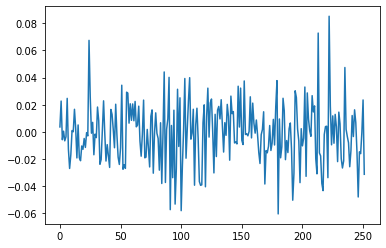

In [67]:
# plt.plot(ohlc.Close)
plt.plot(np.log(ohlc.Close[1:].values / ohlc.Close[0:len(ohlc)-1].values))

Text(0.5, 1.0, 'Implied Volatility - AAPL Calls as of 2022-12-22')

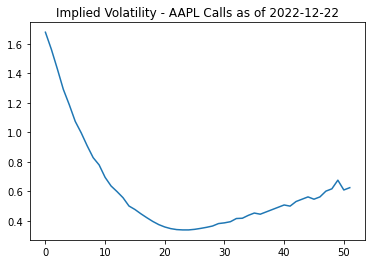

In [72]:
plt.plot(opt.calls.impliedVolatility)
plt.title("Implied Volatility - AAPL Calls as of 2022-12-22")

## Results

In [94]:
opt.puts.iloc[16:21,:]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
16,AAPL230217P00125000,2022-12-22 15:55:41+00:00,125.0,4.80,4.75,4.80,1.180000,32.596695,987.0,23185,0.376715,False,REGULAR,USD
17,AAPL230217P00130000,2022-12-22 15:55:09+00:00,130.0,6.65,6.60,6.65,1.520000,29.629630,1878.0,37959,0.358649,False,REGULAR,USD
18,AAPL230217P00135000,2022-12-22 15:53:32+00:00,135.0,8.90,8.90,8.95,1.800000,25.352108,714.0,22421,0.338141,True,REGULAR,USD
19,AAPL230217P00140000,2022-12-22 15:50:15+00:00,140.0,11.77,11.80,11.90,2.270001,23.894741,229.0,25823,0.322394,True,REGULAR,USD
20,AAPL230217P00145000,2022-12-22 15:53:42+00:00,145.0,15.18,15.20,15.35,2.700001,21.634620,67.0,20667,0.303718,True,REGULAR,USD


In [103]:
actual_put = (opt.puts.iloc[16:21,:]["bid"].values + opt.puts.iloc[16:21,:]["ask"].values)/2
actual_call = (opt.calls.iloc[16:21,:]["bid"].values + opt.calls.iloc[16:21,:]["ask"].values)/2
actuals = np.array([actual_put, actual_call]).T
actuals

array([[ 4.775, 12.225],
       [ 6.625,  9.075],
       [ 8.925,  6.4  ],
       [11.85 ,  4.275],
       [15.275,  2.755]])

In [104]:
sig = np.std(np.log(ohlc.Close[1:].values / ohlc.Close[0:len(ohlc)-1].values))*np.sqrt(252)   # .35367
nsims = 10000
S0 = 131.679
T = .226
discrete_freq = 252
OP_TYPE = "call"
K = 140.0
r = .0368
POLY_DEGREE = 5

In [105]:
lsm = []
for i in range(120, 145, 5):
    put_price = lsm_pricer("ap", nsims, S0, i, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = lsm_pricer("ac", nsims, S0, i, r, sig, T, discrete_freq, POLY_DEGREE)
    lsm.append((put_price, call_price))
    # print("LSM MC American Put ",str(i),"): ", put_price)
    # print("LSM MC American call ",str(i), "):", call_price)
lsm = np.array(lsm)

bt = []
for i in range(120, 145, 5):
    # Without control variates
    put_price = btree_pricer(S0, i, sig, r, T, 1000, "ap")
    call_price = btree_pricer(S0, i, sig, r, T, 1000, "ac")
    bt.append((put_price, call_price))
    # print("BT American Put (",str(i),"):", put_price)
    # print("BT American call (",str(i), "):", call_price)
bt = np.array(bt)

In [112]:
bt

array([[ 3.55460343, 16.20025431],
       [ 5.29683228, 12.96637245],
       [ 7.4943044 , 10.17952182],
       [10.13931298,  7.82940191],
       [13.23821219,  5.92451275]])

In [119]:
pd.DataFrame(np.hstack(np.array([actuals, lsm, bt]))).to_excel("aapl_recent_calculation.xlsx")

In [106]:
fnsims = []
for i in range(1000, 10000, 500):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = lsm_pricer("ac", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    fnsims.append((put_price, call_price))
fnsims = np.array(fnsims)

In [108]:
fnsims

array([[13.29442095,  6.18356414],
       [13.7230524 ,  5.95985839],
       [13.30781465,  6.09500737],
       [13.11003361,  5.75625375],
       [13.22589103,  5.69510796],
       [13.19839027,  6.08390127],
       [13.19693725,  5.65449675],
       [13.0801784 ,  5.70624802],
       [13.20208093,  6.13188839],
       [13.21538251,  5.82814577],
       [13.33388367,  5.74426305],
       [13.33433845,  5.76839753],
       [13.02505792,  5.48337994],
       [13.23225139,  5.83841184],
       [13.15351989,  5.77957346],
       [13.02650123,  5.80425121],
       [13.35433604,  5.68292748],
       [13.38333957,  5.71924375]])

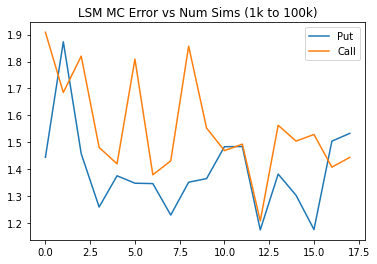

In [121]:
# put and call error vs num sims
plt.plot(fnsims - actuals[3])
plt.legend(["Put", "Call"])
plt.title("LSM MC Error vs Num Sims (1k to 100k)")
plt.show()

In [122]:
fntree = []
for i in range(12, 4000, 10):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = btree_pricer(S0, K, sig, r, T, i, "ac")
    put_price = btree_pricer(S0, K, sig, r, T, i, "ap")
    fntree.append((put_price, call_price))
fntree = np.array(fntree)

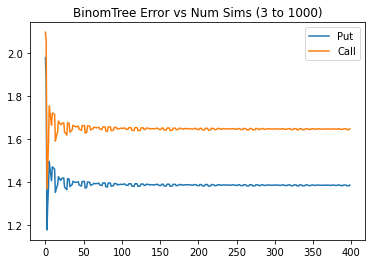

In [123]:
# put and call error vs num sims
plt.plot(fntree - actuals[3])
plt.legend(["Put", "Call"])
plt.title("BinomTree Error vs Num Sims (3 to 1000)")
plt.show()

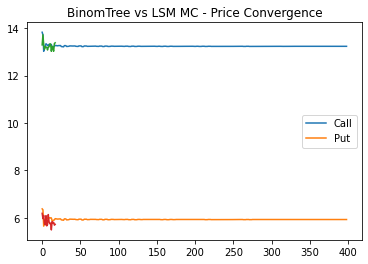

In [125]:
plt.plot(fntree)
plt.plot(fnsims)
plt.title("BinomTree vs LSM MC - Price Convergence")
plt.legend(["Call", "Put"])
plt.show()